#### imports

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from copy import deepcopy
from scipy.integrate import solve_ivp
from itertools import combinations_with_replacement
from emn_model import (
    get_clean_dataset, generate_bipartite_network, diffusion_dynamics, tree_project_network
)
from helper_functions import F_test
from scipy import stats
from forest_generator import generate_barabasi_forest


#### Visualization

In [2]:
TEX_PLOTS = True

# Plotting config
if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
    plt.rc("text.latex", preamble=r"""
         \usepackage{times}
         \usepackage{mathptmx}
         \usepackage{siunitx}""")
else:
    plt.rc("text", usetex=False)

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.labelsize"] = mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.2
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["lines.linewidth"] = 1

cmap = mpl.cm.get_cmap("Dark2")
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=cmap.colors)

np.random.seed(1231)

# Background

### Tree classification

I have removed the cohorts and group them by diameter. The groups are based on their diameter, which signifies their relative age-group. *Note: this is based on the diameter at the beginning of the simulation!.*

* Saplings (young trees): 0 $<$ d $\le$ 15, diameter sizes
* Maturing trees: 15$<$ d $\le$ 35, diameter sizes
* Established trees: 35$<$ d, diameter sizes 

It the current data-set the diameters range from $0.56$ to $53$ diameter sizes. It might be a good idea to sample between $1$ and $55$ (but whatever works). 

### Macro-statistics

The main interest of our model is to what extent older trees (with more resources) are capable of facilitating the success of young trees in terms of carbon transfer. I have thought of a few macro-statistics, but please feel free to add more.  

#### Sapling Succes 

We do not have mortality in our model, so we have to define succes ourselves.

Considering the sapling group, a sapling is succesful when: 
* Succesful: diameter grew with x  or more amount. 
* Unsuccesful: diameter grew less than x amount. 

**x is chosen below, called success_threshold**.


#### Sapling Competition

In our model some saplings are way better growers than others, regardless of size. This is potentially due to its connections. Hence, a measure that resembles this competition will be nice.

Measure of competition (Among samplings): 
* Standard deviation of the growth percentage. 


#### Nutrient diffusion
?? any ideas? Something about how well and far nutrients can diffuse? 

# Results

### Initialization of the network.

In [3]:
df = get_clean_dataset()
B = generate_bipartite_network(df)
G = tree_project_network(B)

In [5]:
N = len(G.nodes)

plant_carbon_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
root_carbon_0 = 0.1 * plant_carbon_0
plant_diameter_0 = np.array(list(nx.get_node_attributes(G, "diameter").values()))

t_range = (0, 16_000)
D_C = 5.0e-4 # carbon diffusion coeff
uptake_ps = (0.55, 0.0, 55.0)

f = 5.0e-4 # sensitive w.r.t plant carbon deposition
k = 0.6
g = 0.004
c = 0.82
rho = 0.01

sol = solve_ivp(diffusion_dynamics, t_range, np.concatenate([root_carbon_0, plant_carbon_0, plant_diameter_0]),
                args=(G, D_C, N, uptake_ps, f, k, c, g, rho), dense_output=True, method="BDF")

time_steps = 300
t = np.linspace(t_range[0], t_range[1], time_steps)
z = sol.sol(t)

#Rename the quantities of interest
roots_carbon, plant_carbon, plant_diameter = z[:N, :], z[N:2*N, :], z[2*N:3*N, :] 

In [6]:
nodes_by_cohort = {"Sapling": [], "Maturing": [], "Established": []}
node_list = list(G.nodes)

for node in G.nodes:
    nodes_by_cohort[G.nodes[node]["cohort"]].append(node)
    
#dictionary of degrees
degrees_dict = {n: d for n, d in G.degree()}

### Group information

In [7]:
success_threshold = 5

Cohort Sapling grew on average 6.59 cm
Cohort Sapling grew on average 251.92% +- 169.99

 #### Sapling statistics #######
Sapling competition between samplings (std growth percentage) 3.54%
15 out of the 24 Saplings were successful. That is 62.50%


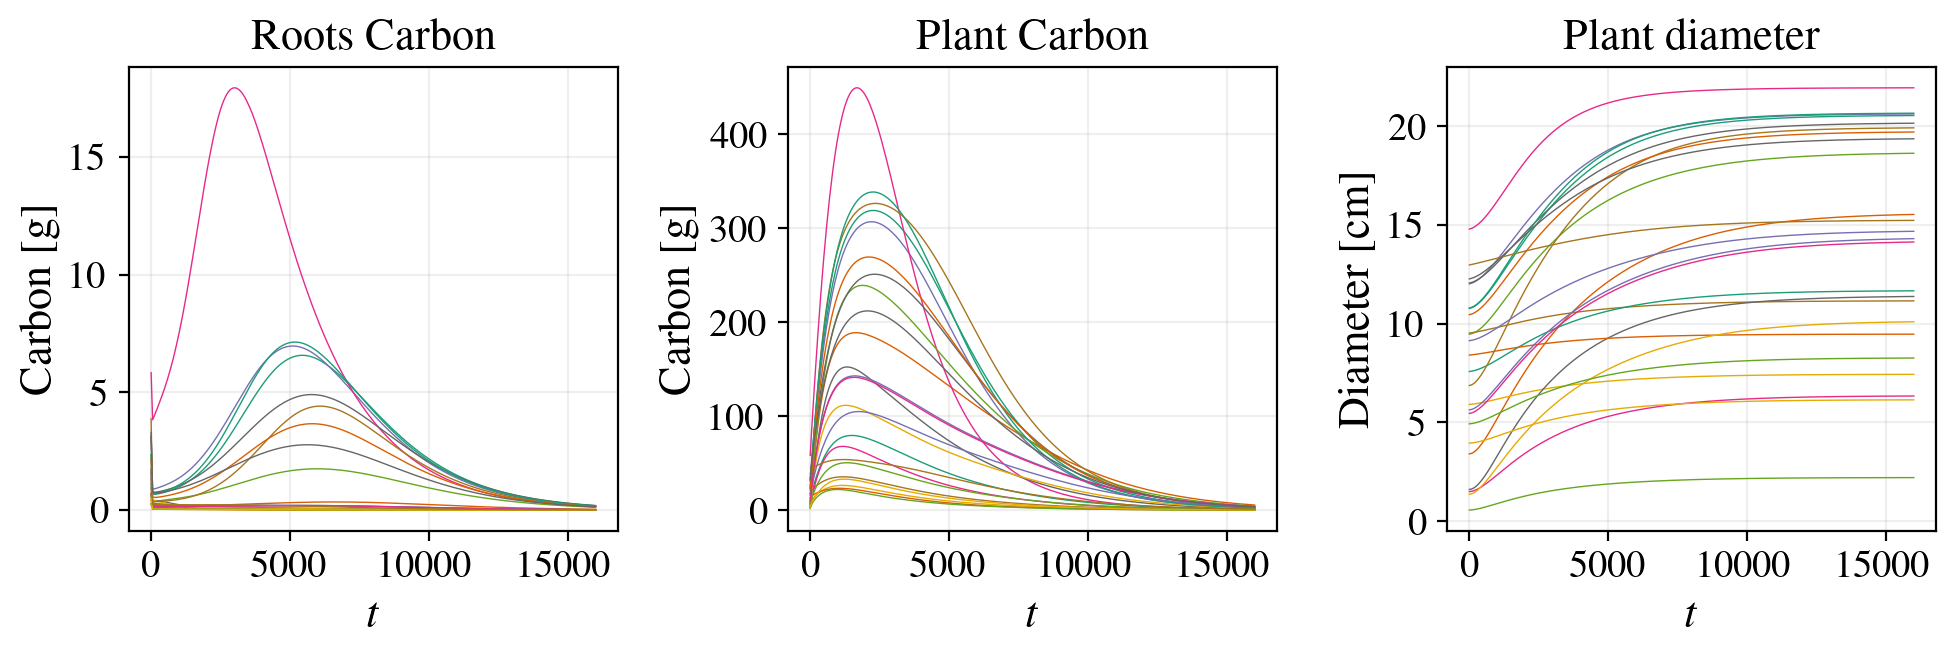

Cohort Maturing grew on average 2.04 cm
Cohort Maturing grew on average 110.17% +- 9.77


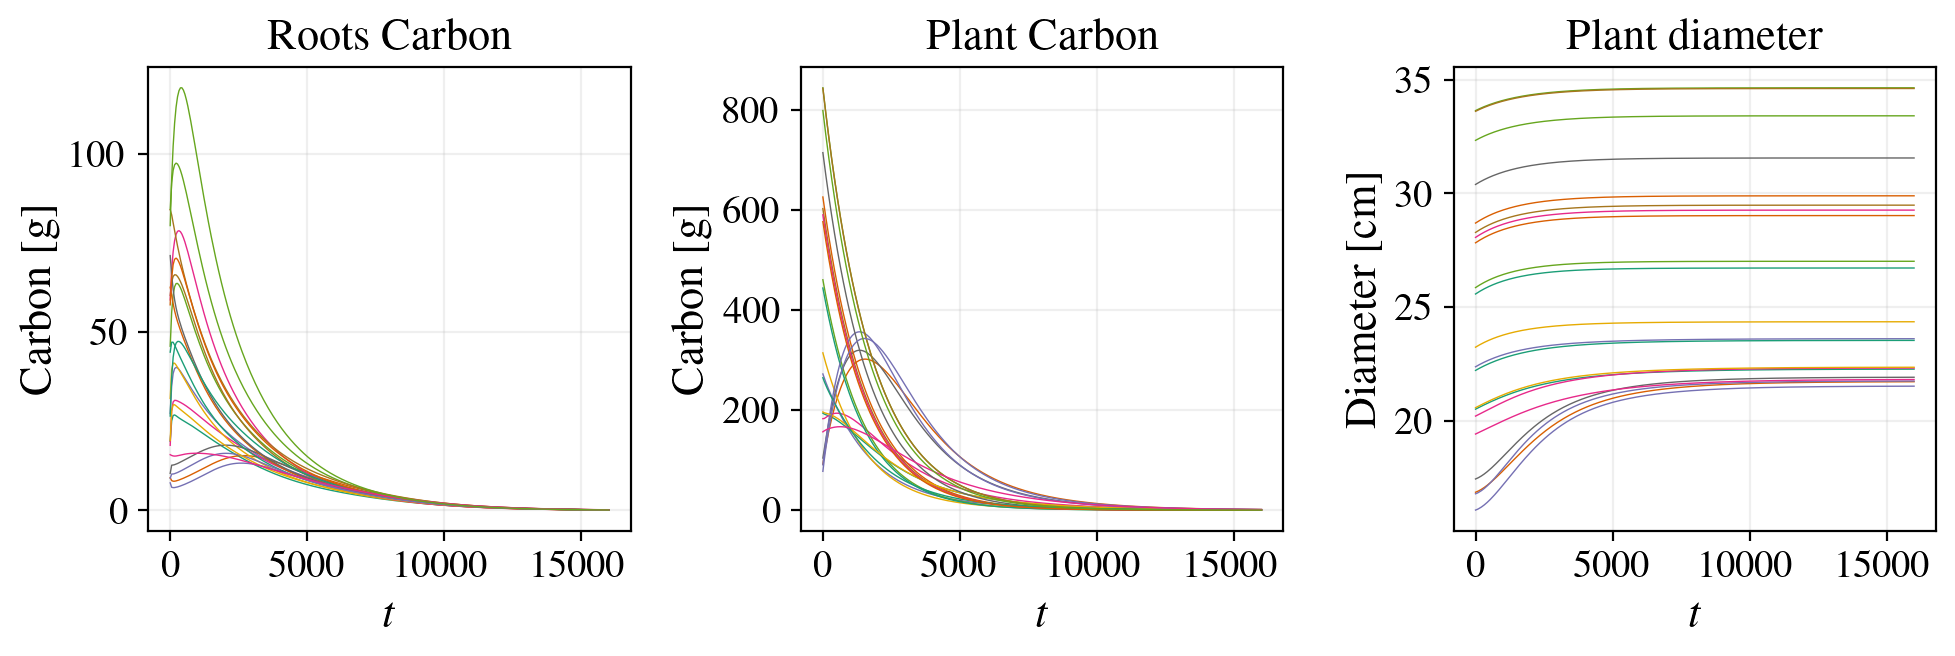

Cohort Established grew on average 0.35 cm
Cohort Established grew on average 100.82% +- 0.56


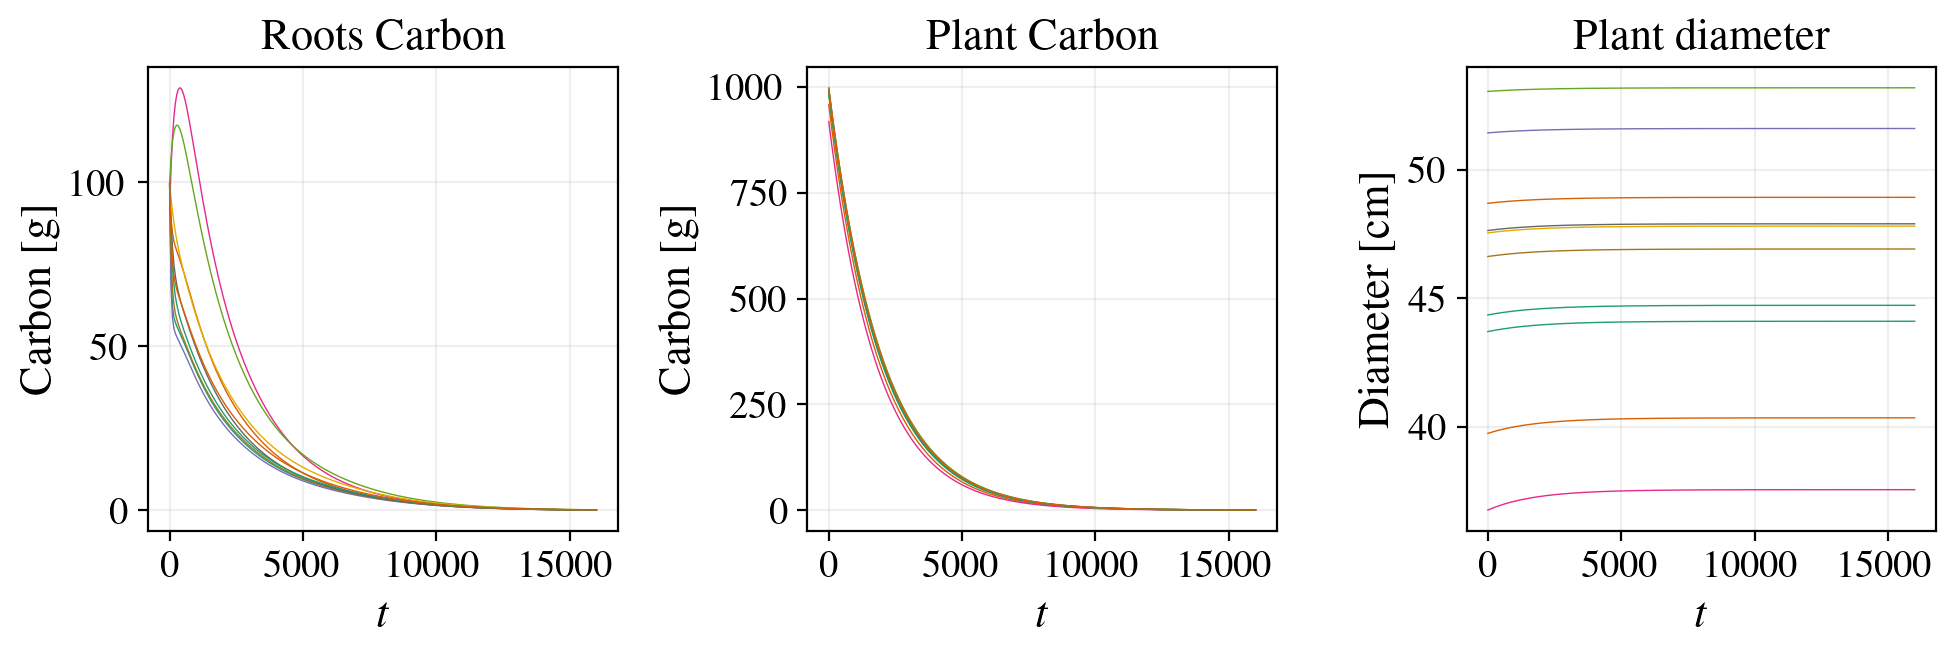

In [8]:
for cohort, nodes in nodes_by_cohort.items():
    
    node_idxs = [node_list.index(node) for node in nodes]
    
    #Calculate Average growth
    growth = plant_diameter[node_idxs, -1] - plant_diameter[node_idxs, 0]
    growth_mean = np.mean(growth)
    growth_stdev = np.std(growth)
    
    #Calculate growth in percantages
    percentages = plant_diameter[node_idxs, -1]/plant_diameter[node_idxs, 0]*100
    percentage_mean = np.mean(percentages)
    percentage_stdev = np.std(percentages)

    print(f"Cohort {str(cohort)} grew on average {growth_mean:.2f} cm")
    print(f"Cohort {str(cohort)} grew on average {percentage_mean:.2f}% +- {percentage_stdev:.2f}")
    
    if cohort == "Sapling": 
        n_successes =  np.sum([growth >= success_threshold])     #np.sum([percentages >= 200])
        
        print("\n #### Sapling statistics #######")
        print(f"Sapling competition between samplings (std growth percentage) {growth_stdev:.2f}%")
        print(f"{n_successes} out of the {len(growth)} Saplings were successful. That is {n_successes/len(growth)*100:.2f}%")

        
    #print(percentages)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

    axes[0].set_title("Roots Carbon")
    axes[0].plot(t, roots_carbon[node_idxs, :].T, linewidth=0.5)
    axes[0].set_xlabel("$t$")
    axes[0].set_ylabel("Carbon [g]")

    axes[1].set_title("Plant Carbon")
    axes[1].plot(t, plant_carbon[node_idxs, :].T, linewidth=0.5)
    axes[1].set_xlabel("$t$")
    axes[1].set_ylabel("Carbon [g]")

    axes[2].set_title("Plant diameter")
    axes[2].plot(t, plant_diameter[node_idxs, :].T, linewidth=0.5)
    axes[2].set_xlabel("$t$")
    axes[2].set_ylabel("Diameter [cm]")

    plt.tight_layout()
    plt.show()

### Nutrient flows

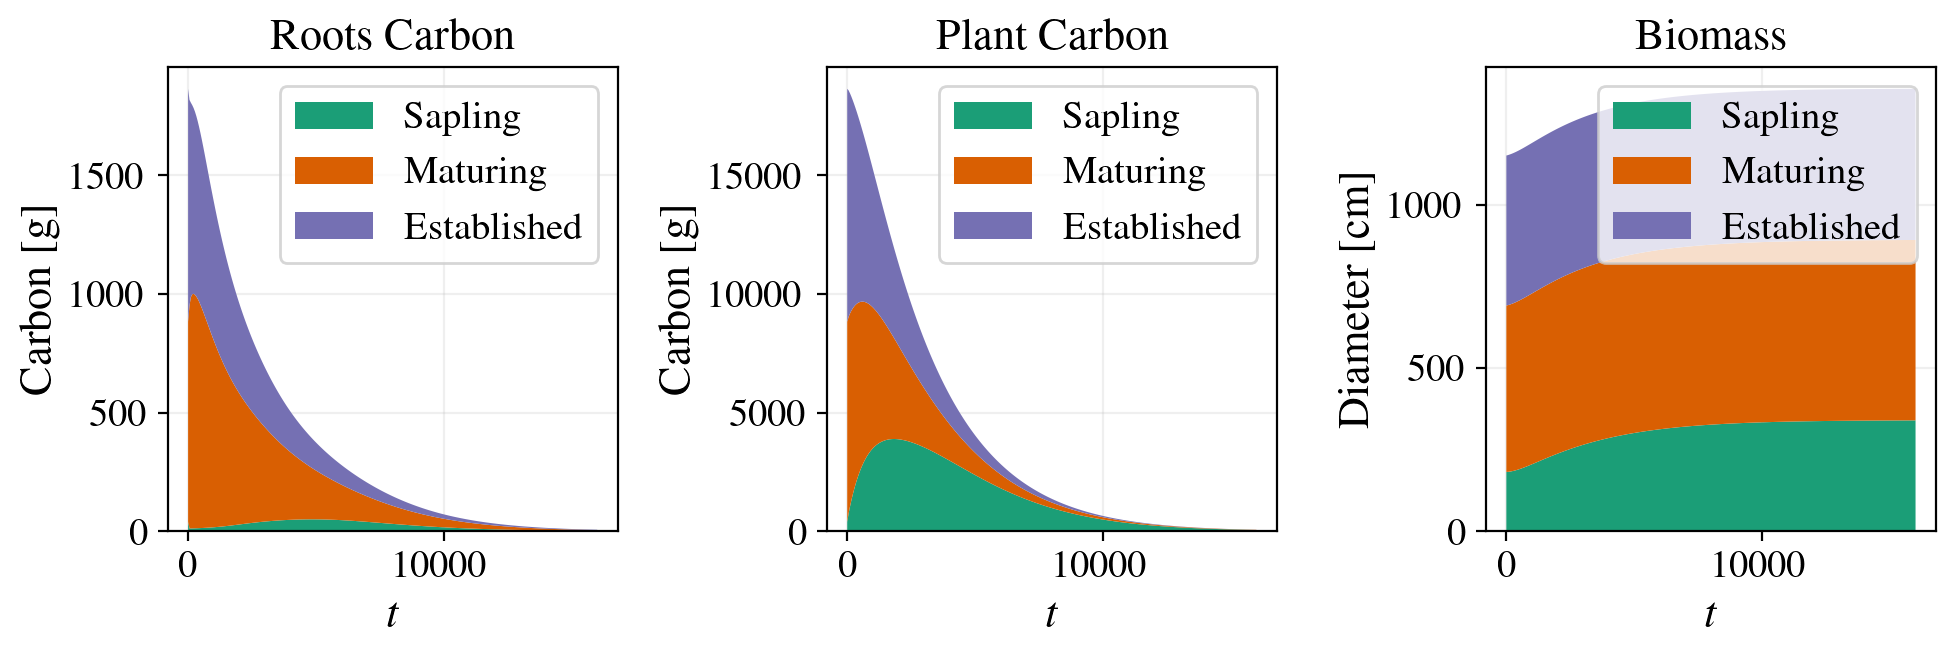

In [103]:
roots_carbon_per_cohort = {}
plant_carbon_per_cohort = {}
plant_diameter_per_cohort = {}


for cohort, nodes in nodes_by_cohort.items():
    
    node_idxs = [node_list.index(node) for node in nodes]
    
    #not sure if total diameter makes sense, but currently included to show growth. 
    total_diameter = np.sum(plant_diameter[node_idxs, :], axis = 0)
    total_plant_carbon = np.sum(plant_carbon[node_idxs, :], axis = 0)
    totaL_root_carbon  = np.sum(roots_carbon[node_idxs, :], axis = 0)
    
    roots_carbon_per_cohort[cohort] = totaL_root_carbon
    plant_carbon_per_cohort[cohort] = total_plant_carbon
    plant_diameter_per_cohort[cohort] = total_diameter
    

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

axes[0].set_title("Roots Carbon")
axes[0].stackplot(t, np.array(list(roots_carbon_per_cohort.values())))
axes[0].legend(labels = np.array(list(roots_carbon_per_cohort.keys())))
axes[0].set_ylabel("Carbon [g]")
axes[0].set_xlabel("$t$")


axes[1].set_title("Plant Carbon")
axes[1].stackplot(t, np.array(list(plant_carbon_per_cohort.values())))
axes[1].legend(labels = np.array(list(plant_carbon_per_cohort.keys())))
axes[1].set_ylabel("Carbon [g]")
axes[1].set_xlabel("$t$")


axes[2].set_title("Biomass")
axes[2].stackplot(t, np.array(list(plant_diameter_per_cohort.values())))
axes[2].legend(labels = np.array(list(plant_diameter_per_cohort.keys())))
axes[2].set_ylabel("Diameter [cm]")
axes[2].set_xlabel("$t$")

 
plt.tight_layout()
plt.show()

### Growth Statistics

#### percentage growth depending on degree ($k$)

Malou to Chaitanya - how valid is this plot? it is the same plot used with the ants for abm. Maybe it is a bit sketchy but love to discuss this with you.

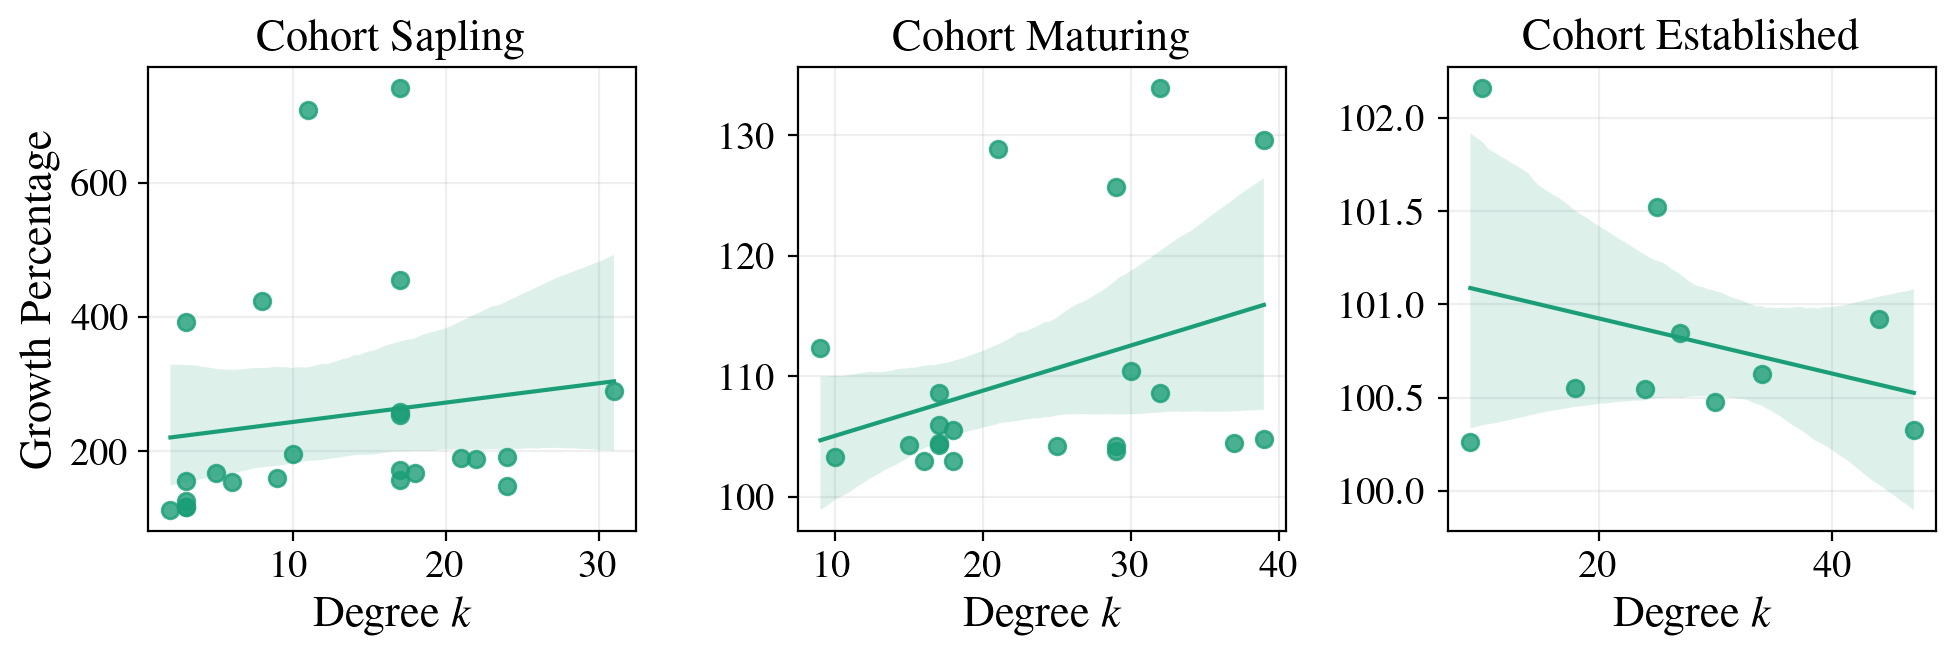

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)
i = 0

for cohort, nodes in nodes_by_cohort.items():
    degrees = []
    growth_percentages = []
    
    for node in nodes: 
        
        node_idx = node_list.index(node)
        degree = degrees_dict[node]
        percentage = plant_diameter[node_idx, -1]/plant_diameter[node_idx, 0]*100
        
        degrees.append(degree)
        growth_percentages.append(percentage)
    
    axes[i].set_title(f"Cohort {cohort}")
    axes[i].set_xlabel(r"Degree $k$")
    sns.regplot(x=degrees, y=growth_percentages, ax=axes[i])
    if i ==0:
        axes[i].set_ylabel(r"Growth Percentage")

    
    i+= 1

plt.tight_layout()
plt.show()

#### percentage growth depending on diameter size ($d$)

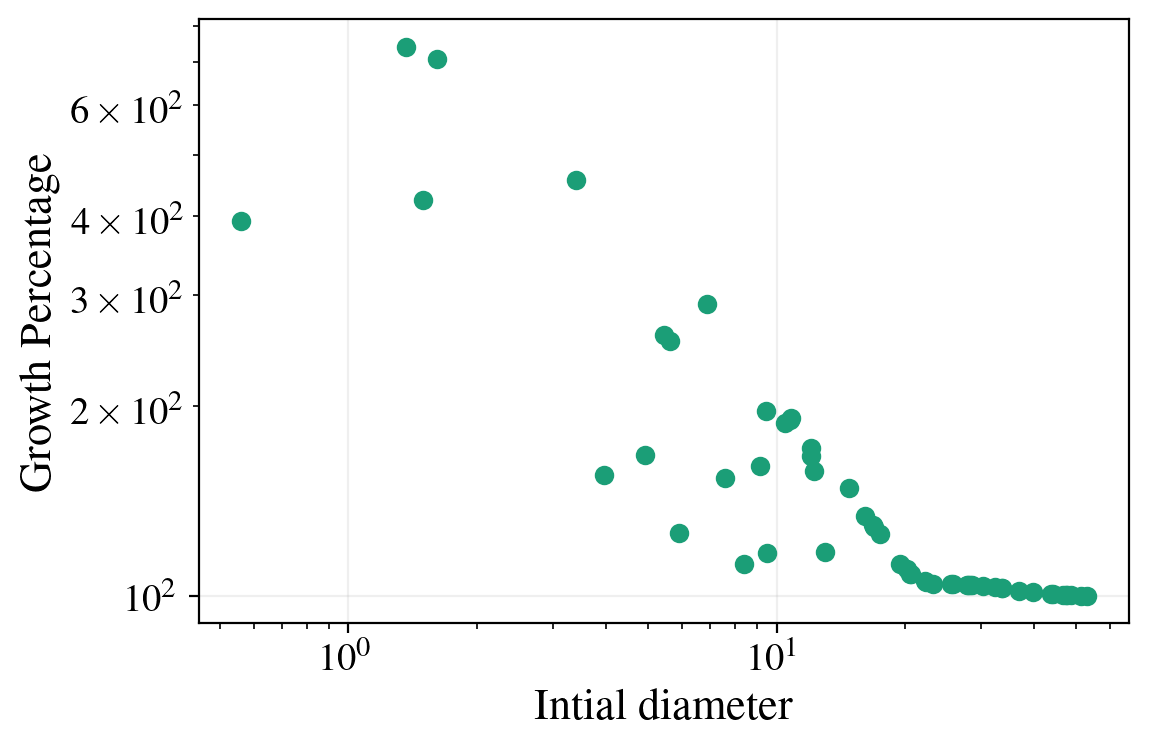

In [11]:
growth_percentages = plant_diameter[:, -1]/plant_diameter[:, 0]*100
initial_diameter = plant_diameter[:, 0]

plt.scatter(initial_diameter, growth_percentages)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Growth Percentage")
plt.xlabel("Intial diameter")
plt.show()

### Sapling Success 

questions to answer here: what makes a sapling successful? Let us take a closer look at the winners and losers of the network: 

Succesful nodes [ 1  5  8  9 11 24 27 30 32 35 36 37 38 40 51]
Unsuccesful nodes [12 13 25 26 28 29 41 43 46]


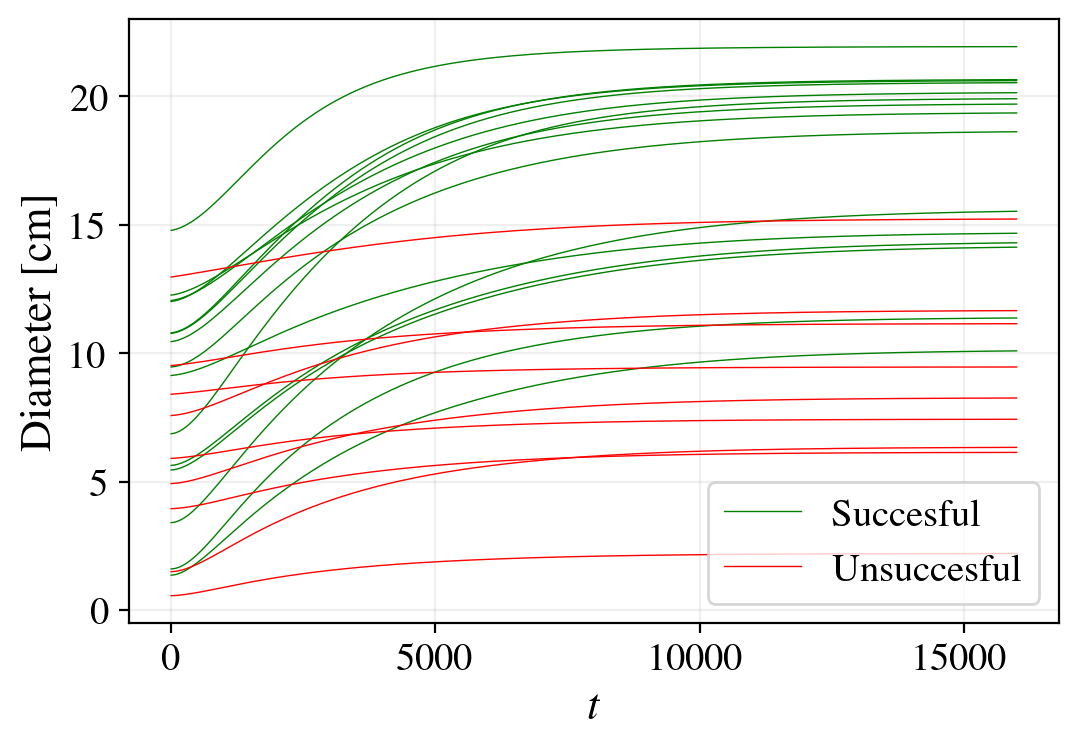

In [73]:
sapling_nodes = nodes_by_cohort["Sapling"]
node_idxs = np.array([node_list.index(node) for node in sapling_nodes])
growth = plant_diameter[node_idxs, -1] - plant_diameter[node_idxs, 0]

successful_nodes = node_idxs[growth >= success_threshold]
unsuccessful_nodes = node_idxs[growth < success_threshold]

print(f"Succesful nodes {successful_nodes}")
print(f"Unsuccesful nodes {unsuccessful_nodes}")

labels1 = [None]*(len(successful_nodes)-1)
labels1.append("Succesful")

labels2 = [None]*(len(unsuccessful_nodes)-1)
labels2.append("Unsuccesful")

plt.plot(t, plant_diameter[successful_nodes, :].T, linewidth=0.5, color = "green", label = labels1)
plt.plot(t, plant_diameter[unsuccessful_nodes, :].T, linewidth=0.5, color = "red", label = labels2)

plt.xlabel("$t$")
plt.ylabel("Diameter [cm]")
plt.legend()

plt.show()

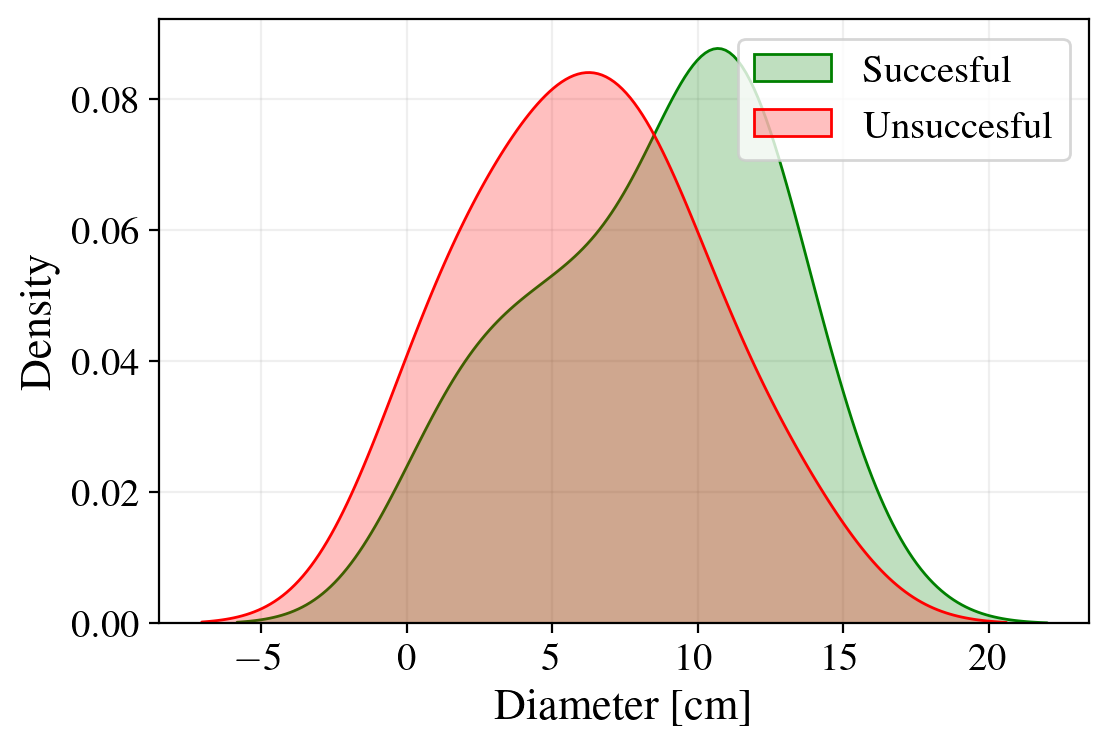

In [75]:
sns.kdeplot(plant_diameter[successful_nodes, 0], color = "green", fill=True, label = "Succesful")
sns.kdeplot(plant_diameter[unsuccessful_nodes, 0], color = "red", fill=True, label = "Unsuccesful")
plt.xlabel("Diameter [cm]")
plt.legend()
plt.show()

In [83]:
statistic_var, p_value_var = F_test(plant_diameter[successful_nodes, 0], plant_diameter[unsuccessful_nodes, 0])
print("Variance test:", p_value_var)

statistic, p_value  = stats.ttest_ind(plant_diameter[successful_nodes, 0], plant_diameter[unsuccessful_nodes, 0], equal_var = True)
print("Mean test:", p_value)

Variance test: 0.4653782851864038
Mean test: 0.20060786041300216


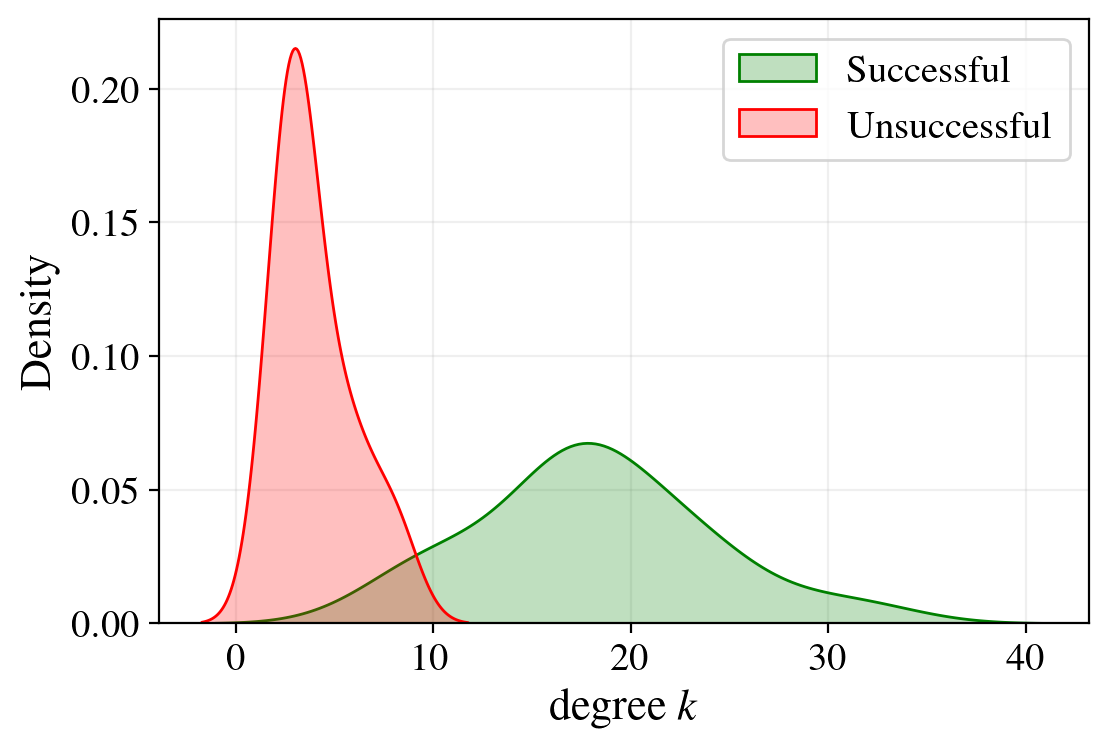

In [84]:
degrees_dict_values = np.array(list(degrees_dict.values()))

sns.kdeplot(degrees_dict_values[successful_nodes], color = "green", fill=True, label="Successful")
sns.kdeplot(degrees_dict_values[unsuccessful_nodes], color = "red", fill=True, label="Unsuccessful")
plt.xlabel("degree $k$")
plt.legend()
plt.show()

In [85]:
statistic_var, p_value_var = F_test(degrees_dict_values[successful_nodes], degrees_dict_values[unsuccessful_nodes])
print("Variance test:", p_value_var)

statistic, p_value  = stats.ttest_ind(degrees_dict_values[successful_nodes], degrees_dict_values[unsuccessful_nodes], equal_var = False)
print("Mean test:", p_value)

Variance test: 0.0020946669079840996
Mean test: 5.510409301519472e-08


The next metric asks: how beneficial are my neighbours? A node can only grow through nutrients from a larger neighbour. The following figure considers the sum of the differences between a node and its neighbours. 

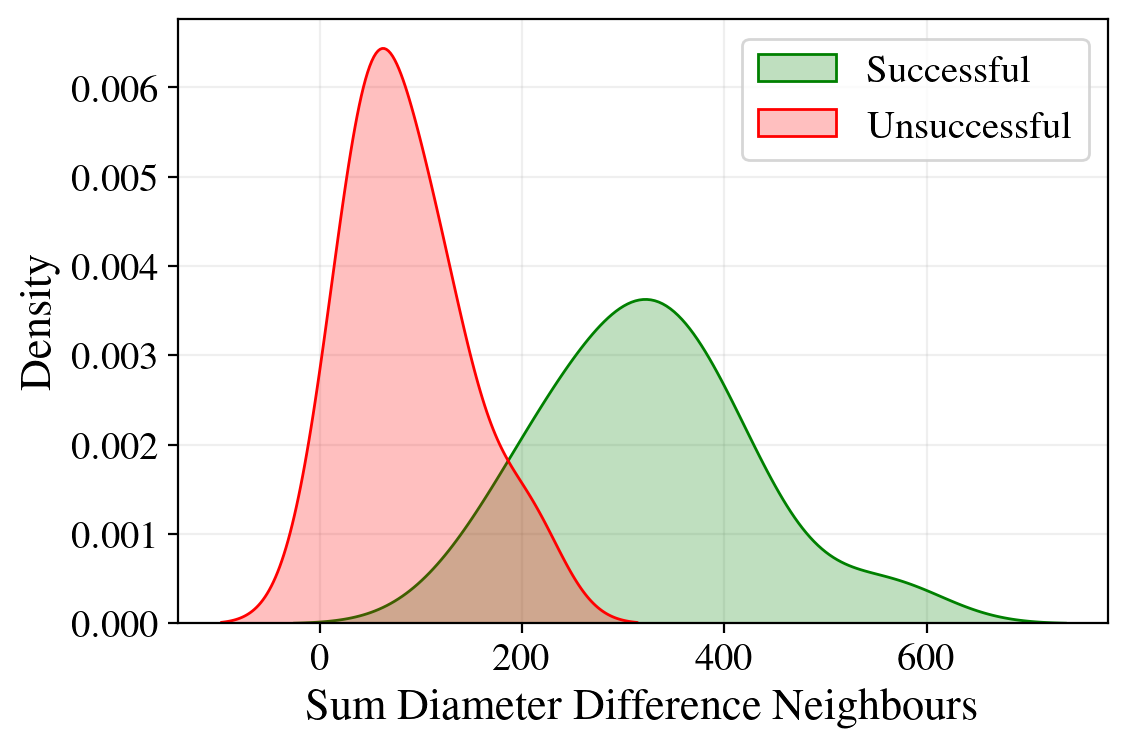

In [88]:
sapling_nodes = nodes_by_cohort["Sapling"]

node_idx_to_neighbour_difference = {}

for node in sapling_nodes: 
    neighbour_differences = 0
    neighbours = [n for n in G.neighbors(node)]
    for neighbour in neighbours:
        node_idx, neighbour_idx = node_list.index(node), node_list.index(neighbour)
        difference = plant_diameter[neighbour_idx, 0] - plant_diameter[node_idx, 0]
        neighbour_differences += difference
    
    node_idx_to_neighbour_difference[node_idx] = neighbour_differences

success_diff = []
for node in successful_nodes:
    success_diff.append(node_idx_to_neighbour_difference[node])

unsuccess_diff = [] 
for node in unsuccessful_nodes:
    unsuccess_diff.append(node_idx_to_neighbour_difference[node])
    
    
sns.kdeplot(success_diff, color="green", fill=True, label="Successful")
sns.kdeplot(unsuccess_diff, color="red", fill=True, label="Unsuccessful")
plt.xlabel("Sum Diameter Difference Neighbours")
plt.legend()
plt.show()

In [89]:
statistic_var, p_value_var = F_test(success_diff, unsuccess_diff)
print("Variance test:", p_value_var)

statistic, p_value  = stats.ttest_ind(success_diff, unsuccess_diff, equal_var = True)
print("Mean test:", p_value)

Variance test: 0.05434087754838257
Mean test: 2.1242084725033237e-06


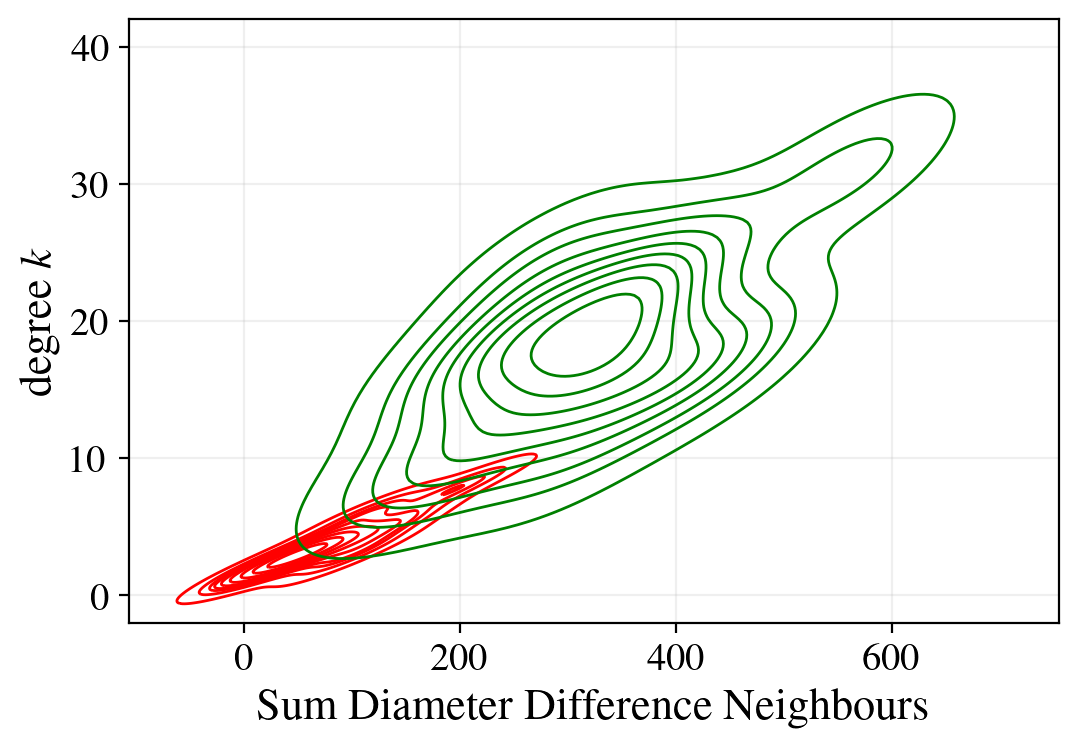

In [102]:
#Not sure how I feel about this
sns.kdeplot(x=unsuccess_diff, y=degrees_dict_values[unsuccessful_nodes], color="red")
sns.kdeplot(x=success_diff, y=degrees_dict_values[successful_nodes], color="green")
plt.xlabel("Sum Diameter Difference Neighbours")
plt.ylabel("degree $k$")
plt.show()